In [ ]:
%pip install drfp
%pip install umap-learn
%pip install hdbscan

In [3]:
import pandas as pd
import numpy as np
from drfp import DrfpEncoder
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Инжиниринг/датасет 4000 реакций (с первых 100 страниц SF).csv', delimiter=';')
#отделяем датасет, где известны все смайлзы
for idx in df.index:
  if 'None' in df.loc[idx, 'reactants_smiles'] or 'None' in df.loc[idx, 'products_smiles']:
    df.drop(labels=idx, inplace=True)
df = df.reset_index(drop=True)

In [5]:
#соединяем смайлзы реагентов и продуктов в общий смайлз реакции
rxn_smiles=[]
for idx in df.index:
  reactants = df.loc[idx, 'reactants_smiles'].split(' ; ')
  reactants = '.'.join(reactants)
  products = df.loc[idx, 'products_smiles'].split(' ; ')
  products = '.'.join(products)
  rxn = reactants + '>>' + products
  rxn_smiles.append(rxn)

In [6]:
#перевод в фингерпринты

list_fps_reaction = []
for i in rxn_smiles:
  fp = DrfpEncoder.encode(i, n_folded_length=2048)
  list_fps_reaction.append(fp)

In [7]:
X = np.array(list_fps_reaction)
X = X.reshape(2776, 2048)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


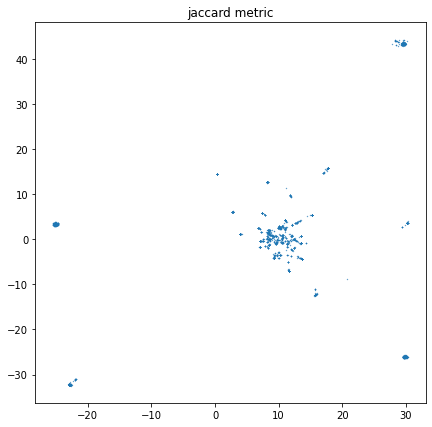

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(


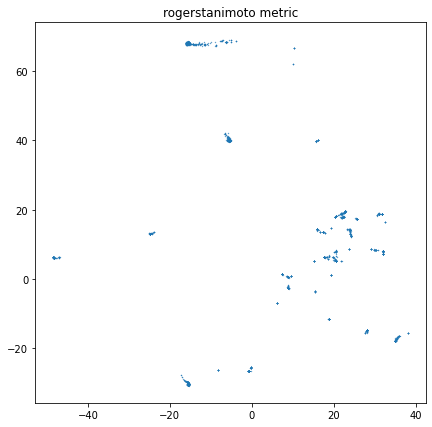

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


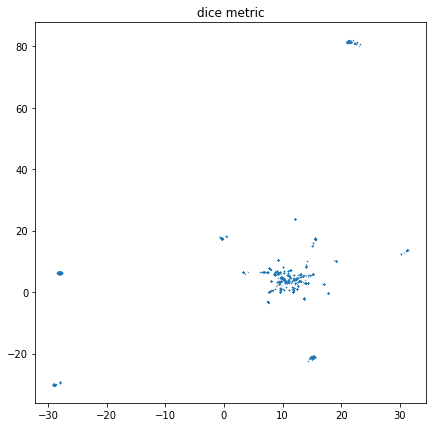

In [151]:
#подбор метрики (брала только метрики для бинарных данных), мне кажется что при jaccard лучше всего видно структуру данных, выбрала ее
for m in ['jaccard', 'rogerstanimoto', 'dice']:
  clusterable_embedding = umap.UMAP(
      n_neighbors=100,
      min_dist=0.0, #взяла 0.0 чтобы классы были более четкие
      n_components=2,
      random_state=42,
      metric=m
  ).fit_transform(X)
  fig, axs = plt.subplots(figsize=(7, 7))
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
  plt.title(f'{m} metric')
  plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


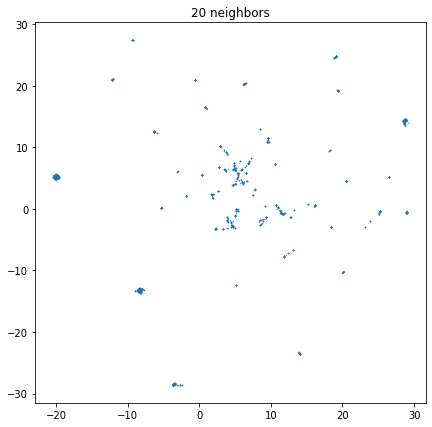

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


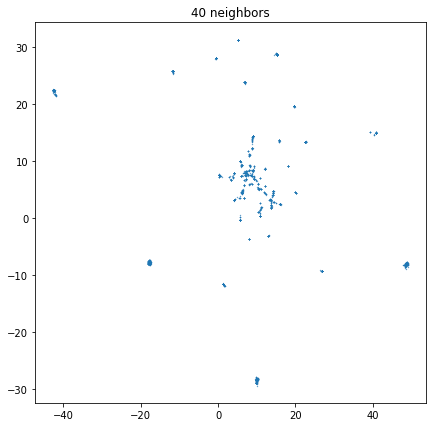

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


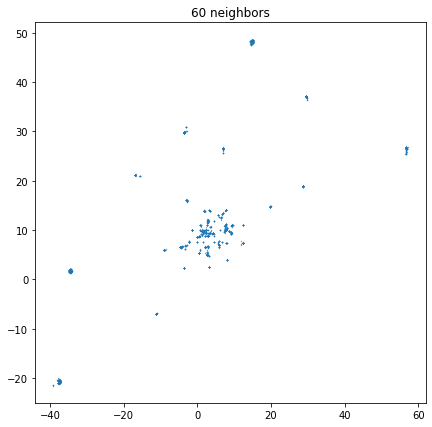

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


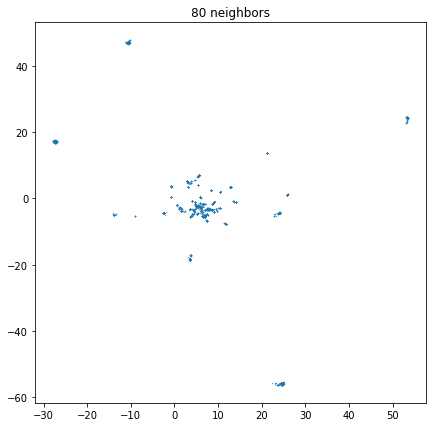

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


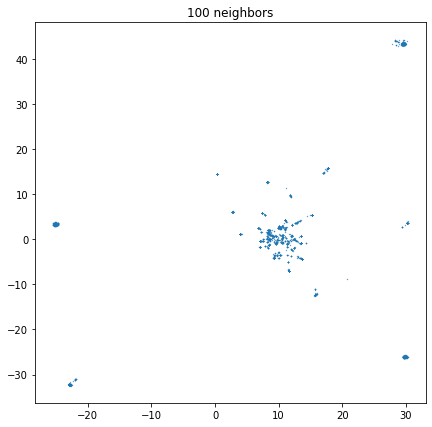

In [177]:
#подбор n_neighbors, тут в начале мне показалось, что какая-то каша, к 100 соседям стало по лучше, взяла 100 (после 100 уже особо ничего не меняется)
for n in range(20, 101, 20):
  clusterable_embedding = umap.UMAP(
      n_neighbors=n,
      min_dist=0.0,
      n_components=2,
      random_state=42,
      metric='jaccard'
  ).fit_transform(X)
  fig, axs = plt.subplots(figsize=(7, 7))
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
  plt.title(f'{n} neighbors')
  plt.show()

In [179]:
#итоговые настройки UMAP
standard_embedding = umap.UMAP(
      n_neighbors=100,
      min_dist=0.0,
      n_components=2,
      random_state=42,
      metric='jaccard'
  ).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


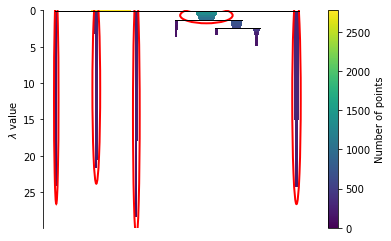

In [182]:
#дендрограмма
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=120
).fit(standard_embedding)
clusterer.condensed_tree_.plot(select_clusters=True)

In [183]:
labels = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=120
).fit_predict(standard_embedding)

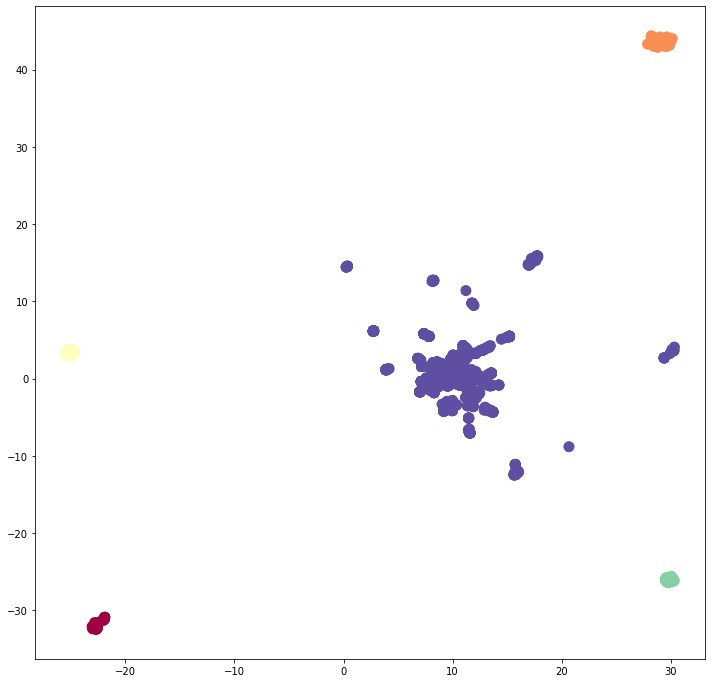

In [184]:
#визуализация после кластеризации
clustered = (labels >= 0)
fig, axs = plt.subplots(figsize=(12, 12))
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=100,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=100,
            cmap='Spectral')

In [154]:
#перемешиваю фингерпринты и отделяю половину
from sklearn.utils import shuffle
X_check = shuffle(X)
X_check = X_check[:1389]

In [186]:
check_embedding = umap.UMAP(
      n_neighbors=100,
      min_dist=0.0,
      n_components=2,
      random_state=42,
      metric='jaccard'
  ).fit_transform(X_check)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


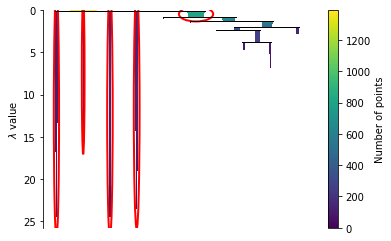

In [197]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=60
).fit(check_embedding)
clusterer.condensed_tree_.plot(select_clusters=True)

In [198]:
labels = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=60
).fit_predict(check_embedding)

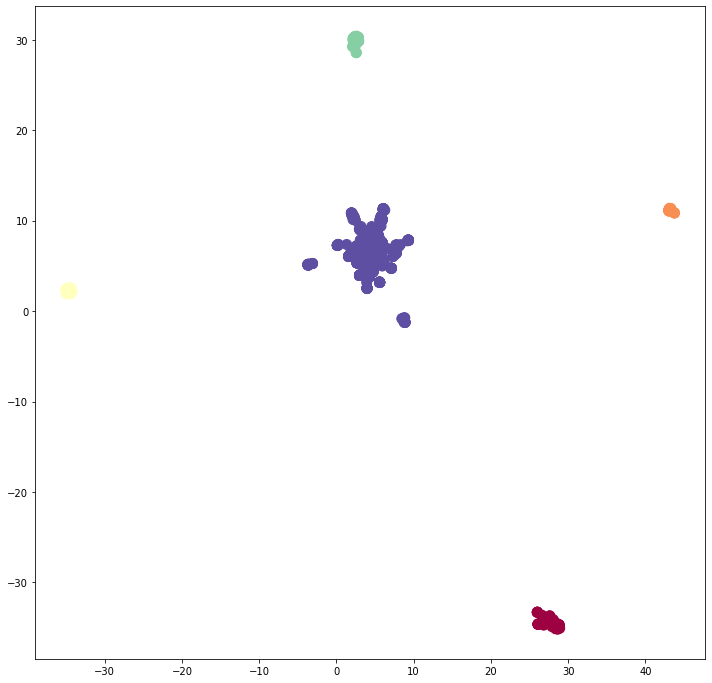

In [199]:
#визуализация после кластеризации
clustered = (labels >= 0)
fig, axs = plt.subplots(figsize=(12, 12))
plt.scatter(check_embedding[~clustered, 0],
            check_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=100,
            alpha=0.5)
plt.scatter(check_embedding[clustered, 0],
            check_embedding[clustered, 1],
            c=labels[clustered],
            s=100,
            cmap='Spectral')